# **4) Model 2**

In [6]:
import os
import csv
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mode

from pyspark.sql import SparkSession, Row
from pyspark.sql.functions import col, lit, pandas_udf
from pyspark.sql.functions import pandas_udf, PandasUDFType
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, FloatType

from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

### Preprocessing for #2:

In [1]:
data_dir = "../msawires1/combined_pkl_csv"
chunk_size = 1000

modality_files = [
    "df_chest_ecg.csv",
    "df_chest_emg.csv",
    "df_chest_eda.csv",
    "df_chest_temp.csv",
    "df_chest_resp.csv",
    "df_wrist_bvp.csv",
    "df_wrist_eda.csv",
    "df_wrist_temp.csv"
]

In [2]:
from scipy.stats import mode, skew

import numpy as np
import pandas as pd

def chunk_and_compute_stats(df, modality_name, chunk_size=1000):
    grouped = df.groupby("subject")
    stats_rows = []

    for subject, group in grouped:
        group = group.sort_values("sample")
        signal_values = group.drop(columns=["subject", "label", "sample"]).values.flatten()
        labels = group["label"].values

        total_chunks = len(labels) // chunk_size
        if total_chunks == 0:
            continue

        signal_values = signal_values[:total_chunks * chunk_size].reshape(total_chunks, chunk_size)
        label_chunks = labels[:total_chunks * chunk_size].reshape(total_chunks, chunk_size)

        for i in range(total_chunks):
            window = signal_values[i]
            majority_label = mode(label_chunks[i], keepdims=False).mode

            stats_rows.append({
                "chunk_id": i,
                "subject": subject,
                "modality": modality_name,
                "label": int(majority_label),
                "mean": np.mean(window),
                "std": np.std(window),
                "min": np.min(window),
                "max": np.max(window),
                "range": np.max(window) - np.min(window),
                "skewness": skew(window),
                "iqr": np.percentile(window, 75) - np.percentile(window, 25),
                "mode": float(mode(window, keepdims=False).mode),
                "median": np.median(window)
            })

    return pd.DataFrame(stats_rows)


In [3]:
# Final output DataFrame
all_chunks = []

for file in modality_files:
    file_path = os.path.join(data_dir, file)
    if os.path.exists(file_path):
        df = pd.read_csv(file_path)
        modality = file.replace("df_", "").replace(".csv", "")
        print(f"Processing {modality}...")
        chunked = chunk_and_compute_stats(df, modality)
        all_chunks.append(chunked)
    else:
        print(f"File not found: {file_path}")

# Combine all
final_df = pd.concat(all_chunks, ignore_index=True)
final_df.head()

Processing chest_ecg...
Processing chest_emg...
Processing chest_eda...
Processing chest_temp...
Processing chest_resp...
Processing wrist_bvp...
Processing wrist_eda...
Processing wrist_temp...


,chunk_id,subject,modality,label,mean,std,min,max,range,skewness,iqr,mode,median
0,0,S10,chest_ecg,1,0.011688,0.122707,-0.418213,0.634689,1.052902,-0.346959,0.067474,0.060379,0.036667
1,1,S10,chest_ecg,1,0.003981,0.151308,-0.566345,0.785843,1.352188,0.100272,0.142422,0.056625,0.033325
2,2,S10,chest_ecg,1,0.005229,0.145675,-0.658127,0.709946,1.368073,-0.401125,0.093452,0.066147,0.033234
3,3,S10,chest_ecg,1,0.002883,0.125497,-0.663895,0.613358,1.277252,-1.002028,0.084835,0.039871,0.037743
4,4,S10,chest_ecg,1,-0.003527,0.120900,-0.461105,0.433273,0.894379,-1.385745,0.089642,0.040237,0.034973


In [4]:
final_df.shape

(160518, 13)

In [5]:
summary = final_df.groupby(['subject', 'label']).size().reset_index(name='count')
print(summary)

   subject  label  count
0      S10      1   4223
1      S10      2   2597
2      S10      3   1328
3      S10      4   2825
4      S11      1   4223
5      S11      2   2431
6      S11      3   1313
7      S11      4   2812
8      S13      1   4223
9      S13      2   2376
10     S13      3   1363
11     S13      4   2823
12     S14      1   4223
13     S14      2   2416
14     S14      3   1333
15     S14      4   2812
16     S15      1   4207
17     S15      2   2454
18     S15      3   1328
19     S15      4   2817
20     S16      1   4223
21     S16      2   2406
22     S16      3   1313
23     S16      4   2819
24     S17      1   4228
25     S17      2   2585
26     S17      3   1328
27     S17      4   2596
28      S2      1   4095
29      S2      2   2197
30      S2      3   1293
31      S2      4   2727
32      S3      1   4080
33      S3      2   2289
34      S3      3   1343
35      S3      4   2767
36      S4      1   4146
37      S4      2   2268
38      S4      3   1328


In [6]:
print(final_df.columns)

Index(['chunk_id', 'subject', 'modality', 'label', 'mean', 'std', 'min', 'max',
       'range', 'skewness', 'iqr', 'mode', 'median'],
      dtype='object')


In [9]:
# Label distribution
print("Label distribution:")
print(final_df['label'].value_counts(normalize=True))

# Basic stats per label
print("\nMean statistics per label:")
print(final_df.groupby('label').mean(numeric_only=True))

# Check for NaNs or weird values
print("\nMissing values:")
print(final_df.isnull().sum())

Label distribution:
label
1    0.392672
4    0.261167
2    0.222069
3    0.124092
Name: proportion, dtype: float64

Mean statistics per label:
          chunk_id      mean       std       min        max      range  \
label                                                                    
1       402.309102  7.360124  1.193495  3.391013  11.054914   7.663901   
2      1317.752118  7.885392  1.545908  2.744271  12.818793  10.074522   
3      1268.462724  7.577633  1.275973  3.274309  11.551105   8.276796   
4      1613.086899  7.689933  0.911904  4.572257  10.587930   6.015674   

       skewness       iqr      mode    median  
label                                          
1      0.891177  1.369549  7.158893  7.429680  
2      0.559434  1.704096  7.361974  7.905027  
3      0.787002  1.437817  7.303022  7.628287  
4      0.709883  0.995212  7.440730  7.728628  

Missing values:
chunk_id    0
subject     0
modality    0
label       0
mean        0
std         0
min         0
max      

### Random Forest: Senors only

In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import pandas as pd

##drop non-numeric or unneeded columns
X = final_df.drop(columns=["subject", "modality", "label", "chunk_id"])
y = final_df["label"]

# split into train+val and test
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# split train+val into train and validation
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp)  # 0.25 x 0.8 = 0.2

# initialize and train model
rf = RandomForestClassifier(n_estimators=100, random_state=45, class_weight='balanced', max_depth=20,                 # <--- try limiting depth
    min_samples_leaf=3)
rf.fit(X_train, y_train)

#predict on all sets
y_train_pred = rf.predict(X_train)
y_val_pred = rf.predict(X_val)
y_test_pred = rf.predict(X_test)

#evaluation
print("Training Accuracy:", accuracy_score(y_train, y_train_pred))
print("Validation Accuracy:", accuracy_score(y_val, y_val_pred))
print("Test Accuracy:", accuracy_score(y_test, y_test_pred))

print("\nClassification Report (Test):")
print(classification_report(y_test, y_test_pred))

# example predictions
example_df = pd.DataFrame({
    "True Label": y_test[:10].values,
    "Predicted Label": y_test_pred[:10]
})
print("\nExample Predictions:")
print(example_df)


Training Accuracy: 0.869951199252414
Validation Accuracy: 0.6696361824071767
Test Accuracy: 0.6746511338151009

Classification Report (Test):
              precision    recall  f1-score   support

           1       0.75      0.73      0.74     12606
           2       0.65      0.64      0.65      7129
           3       0.51      0.51      0.51      3984
           4       0.67      0.70      0.68      8385

    accuracy                           0.67     32104
   macro avg       0.64      0.64      0.64     32104
weighted avg       0.68      0.67      0.67     32104


Example Predictions:
   True Label  Predicted Label
0           3                1
1           1                1
2           3                3
3           2                2
4           4                1
5           4                1
6           1                1
7           2                2
8           1                1
9           2                2


### Post-model analysis

Matplotlib created a temporary cache directory at /scratch/msawires1/job_39930740/matplotlib-4vj3xpg5 because the default path (/home/jovyan/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


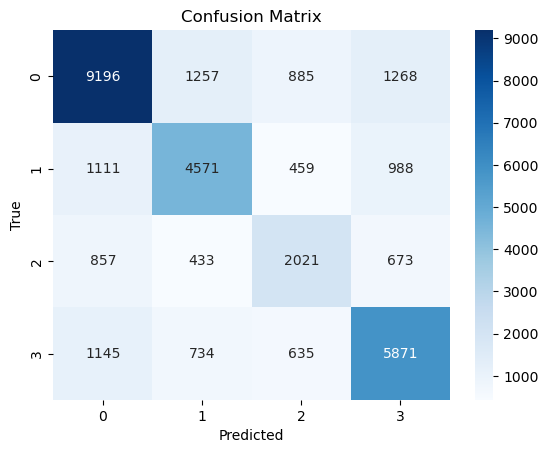

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


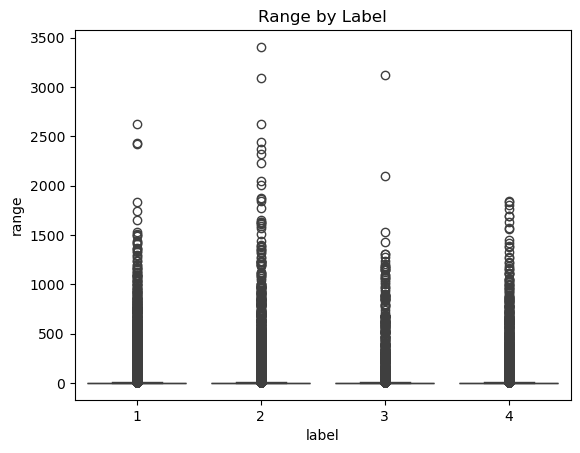

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(data=final_df, x='label', y='range')
plt.title('Range by Label')
plt.show()

In [13]:
# Here we are training the same model, random forest but just  using cross validation to train 
# Since we added range and skewness, theres abt a 2% increase!
# 

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
import numpy as np

X = final_df.drop(columns=["subject", "modality", "label", "chunk_id"])
y = final_df["label"]

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
accuracies = []

for fold, (train_idx, val_idx) in enumerate(skf.split(X, y), 1):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    rf = RandomForestClassifier(
        n_estimators=100,
        random_state=42,
        class_weight='balanced',
        max_depth=20,
        min_samples_leaf=3
    )
    rf.fit(X_train, y_train)
    y_val_pred = rf.predict(X_val)
    acc = accuracy_score(y_val, y_val_pred)
    print(f"Fold {fold} Validation Accuracy: {acc:.4f}")
    accuracies.append(acc)

print(f"\nMean CV Accuracy: {np.mean(accuracies):.4f} ± {np.std(accuracies):.4f}")


Fold 1 Validation Accuracy: 0.6753
Fold 2 Validation Accuracy: 0.6779
Fold 3 Validation Accuracy: 0.6701
Fold 4 Validation Accuracy: 0.6739
Fold 5 Validation Accuracy: 0.6737

Mean CV Accuracy: 0.6742 ± 0.0025


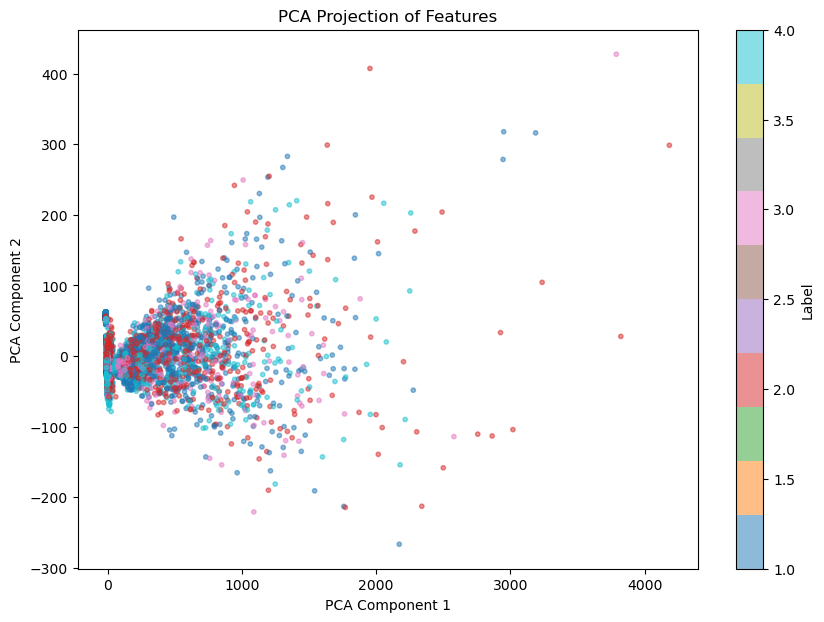

In [14]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

#Plotting the first two PCA Compontents to 2D visual 
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(10, 7))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='tab10', alpha=0.5, s=10)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('PCA Projection of Features')
plt.colorbar(scatter, label='Label')
plt.show()


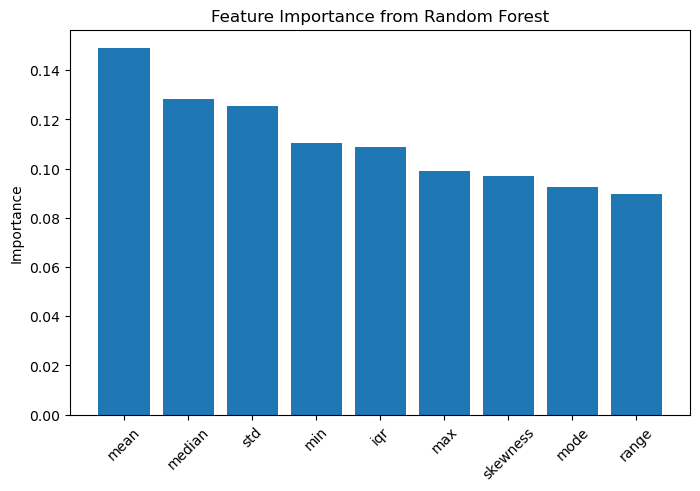

In [15]:
import matplotlib.pyplot as plt
import pandas as pd

# Get feature importances from the trained Random Forest
importances = rf.feature_importances_
feature_names = X.columns

# Create a DataFrame for easy plotting
feat_imp_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

# Plot
plt.figure(figsize=(8,5))
plt.bar(feat_imp_df['feature'], feat_imp_df['importance'])
plt.title("Feature Importance from Random Forest")
plt.ylabel("Importance")
plt.xticks(rotation=45)
plt.show()


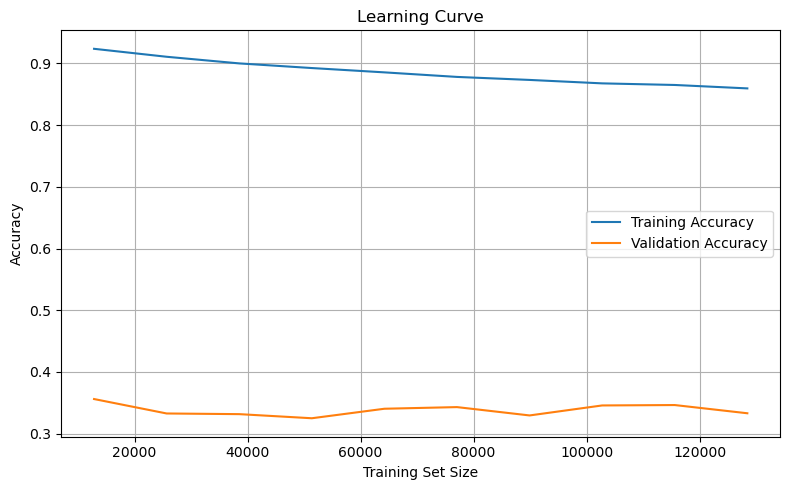

In [63]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
import numpy as np


model = RandomForestClassifier(
        n_estimators=100,
        random_state=42,
        class_weight='balanced',
        max_depth=20,
        min_samples_leaf=3
    )  
X = final_df.drop(columns=["subject", "modality", "label", "chunk_id"])
y = final_df["label"]

train_sizes, train_scores, val_scores = learning_curve(
    estimator=model,
    X=X,
    y=y,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=5,
    scoring='accuracy',
    shuffle=True,
    random_state=42
)


train_mean = np.mean(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)

# Plotting
plt.figure(figsize=(8, 5))
plt.plot(train_sizes, train_mean, label="Training Accuracy")
plt.plot(train_sizes, val_mean, label="Validation Accuracy")
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy")
plt.title("Learning Curve")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()